# Training CGNet

Purpose:
--------
The purpose of this notebook is to train CGnet for machine learning detection of atmospheric rivers and tropical cyclones.\
See ClimateNet repo here: https://github.com/andregraubner/ClimateNet

Authors/Contributors:
---------------------
* Teagan King
* John Truesdale
* Katie Dagon

## Import libraries

In [1]:
import os
import sys
import json
import numpy as np

sys.path.append("/glade/work/kdagon/ClimateNet") # append path to ClimateNet repo
from climatenet.utils.data import ClimateDatasetLabeled, ClimateDataset
from climatenet.models import CGNet
from climatenet.utils.utils import Config
from climatenet.track_events import track_events
from climatenet.analyze_events import analyze_events
from climatenet.visualize_events import visualize_events

from os import path

## Config file
Use `get_averages_and_standard_devs.ipynb` to calculate means/stds for given training dataset.

In [3]:
#config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_021523.json') # weighted mean, unweighted std
config = Config('/glade/work/kdagon/ML-extremes/trained_models/config_040523.json') # unweighted mean and std

In [4]:
config.description

'The basic CGNet model. You can use this config to train your own model, or load it with our trained weights.'

In [5]:
config.train_batch_size

16

## Confirm GPU resources
Can request through JupyterHub launch page.\
Current resources request (2/15/23): 1 node, 4 cpu, 64GB mem, 2 V100 GPU\
4/5/23: Noticed that not all CPU/mem was needed, new request: 1 node, 2 cpu, 64GB mem, 2 V100 GPU

In [6]:
# requires loading pytorch into environment
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
2


## Instantiate CGNet model given config file
This step needs GPU resources (as written)

In [7]:
%%time
cgnet = CGNet(config)

CPU times: user 1.53 s, sys: 823 ms, total: 2.36 s
Wall time: 5.91 s


In [8]:
cgnet.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

## Set train, test data

In [9]:
train_path = "/glade/campaign/cgd/amp/jet/ClimateNet_12012020/portal.nersc.gov/project/ClimateNet/climatenet_new"

train = ClimateDatasetLabeled(path.join(train_path, 'train'), config)
test = ClimateDatasetLabeled(path.join(train_path, 'test'), config)

In [10]:
train.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541},
 'PSL': {'mean': 100814.078125, 'std': 1461.225830078125}}

In [11]:
train.length

398

In [12]:
config.epochs

20

## Train model

Memory use holding at ~14GB during training\
Each epoch takes ~1 min to run

In [11]:
cgnet.train(train) # use ~20 epochs for non-test
# IOU mean should be around 0.75 after all epochs?
# weights and measures site to look at ML performance
# maybe playing with those parameters could improve model

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[2.78531995e+08 6.72942200e+06 4.52592820e+07]
 [1.08767700e+06 2.55390000e+05 2.83280000e+05]
 [6.13705900e+06 2.86185000e+05 1.35546380e+07]]
IOUs:  [0.82468027 0.02955234 0.20687647] , mean:  0.3537030257391982
Epoch 2:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.15751843e+08 6.17951000e+05 1.41509050e+07]
 [9.33112000e+05 5.70046000e+05 1.23189000e+05]
 [7.91498000e+06 7.74230000e+04 1.19854790e+07]]
IOUs:  [0.93040919 0.24552735 0.3499208 ] , mean:  0.5086191152359816
Epoch 3:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16647133e+08 9.03472000e+05 1.29700940e+07]
 [7.70526000e+05 7.50304000e+05 1.05517000e+05]
 [7.34050100e+06 9.66780000e+04 1.25407030e+07]]
IOUs:  [0.93507817 0.28566718 0.37940629] , mean:  0.5333838779624961
Epoch 4:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.16947454e+08 8.77425000e+05 1.26958200e+07]
 [7.06508000e+05 8.23130000e+05 9.67090000e+04]
 [6.92779000e+06 8.88940000e+04 1.29611980e+07]]
IOUs:  [0.93728455 0.31748401 0.39551527] , mean:  0.5500946104927246
Epoch 5:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17398185e+08 9.41980000e+05 1.21805340e+07]
 [6.69957000e+05 8.61272000e+05 9.51180000e+04]
 [6.79240500e+06 8.73890000e+04 1.30980880e+07]]
IOUs:  [0.93909495 0.32430877 0.40609776] , mean:  0.5565004948355418
Epoch 6:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17065522e+08 9.67129000e+05 1.24880480e+07]
 [6.55249000e+05 8.80964000e+05 9.01340000e+04]
 [6.55202100e+06 8.93240000e+04 1.33365370e+07]]
IOUs:  [0.93881926 0.32837483 0.40964832] , mean:  0.5589474716004018
Epoch 7:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17717152e+08 9.95832000e+05 1.18077150e+07]
 [6.18039000e+05 9.20317000e+05 8.79910000e+04]
 [6.48024000e+06 8.17700000e+04 1.34158720e+07]]
IOUs:  [0.94105241 0.34036034 0.42090875] , mean:  0.5674404981127523
Epoch 8:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17487741e+08 1.00464000e+06 1.20283180e+07]
 [6.05835000e+05 9.32707000e+05 8.78050000e+04]
 [6.30584400e+06 8.16000000e+04 1.35904380e+07]]
IOUs:  [0.94089294 0.34384409 0.42345722] , mean:  0.5693980796959953
Epoch 9:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17660038e+08 1.04944000e+06 1.18112210e+07]
 [5.98268000e+05 9.47097000e+05 8.09820000e+04]
 [6.23379400e+06 8.49440000e+04 1.36591440e+07]]
IOUs:  [0.94162572 0.34306023 0.42858825] , mean:  0.571091400527525
Epoch 10:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18126988e+08 1.08512600e+06 1.13085850e+07]
 [5.82093000e+05 9.64273000e+05 7.99810000e+04]
 [6.09597700e+06 8.53570000e+04 1.37965480e+07]]
IOUs:  [0.94344054 0.34477355 0.43985051] , mean:  0.5760215301028927
Epoch 11:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.17898837e+08 1.05577400e+06 1.15660880e+07]
 [5.71586000e+05 9.72257000e+05 8.25040000e+04]
 [5.98275700e+06 7.99790000e+04 1.39151460e+07]]
IOUs:  [0.94310998 0.3519992  0.43998411] , mean:  0.578364431877742
Epoch 12:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18118161e+08 1.07088500e+06 1.13316530e+07]
 [5.77152000e+05 9.65909000e+05 8.32860000e+04]
 [5.86323000e+06 8.24850000e+04 1.40321670e+07]]
IOUs:  [0.94407983 0.34748465 0.44698649] , mean:  0.5795169936411225
Epoch 13:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18262515e+08 1.08712200e+06 1.11710620e+07]
 [5.60269000e+05 9.86589000e+05 7.94890000e+04]
 [5.79587100e+06 8.31810000e+04 1.40988300e+07]]
IOUs:  [0.94474442 0.35277528 0.45147414] , mean:  0.582997950077657
Epoch 14:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18219608e+08 1.09886500e+06 1.12022260e+07]
 [5.50183000e+05 9.95290000e+05 8.08740000e+04]
 [5.64612100e+06 8.02620000e+04 1.42514990e+07]]
IOUs:  [0.94506546 0.35476714 0.45588776] , mean:  0.5852401195562419
Epoch 15:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18347151e+08 1.07947900e+06 1.10940690e+07]
 [5.46918000e+05 9.95365000e+05 8.40640000e+04]
 [5.67994800e+06 8.43080000e+04 1.42136260e+07]]
IOUs:  [0.94535843 0.35674451 0.45620809] , mean:  0.5861036788703384
Epoch 16:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18090262e+08 1.13052800e+06 1.12999090e+07]
 [5.31569000e+05 1.01557900e+06 7.91990000e+04]
 [5.57869900e+06 8.48910000e+04 1.43142920e+07]]
IOUs:  [0.94492276 0.35737601 0.45649445] , mean:  0.5862644079084163
Epoch 17:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18307796e+08 1.04556700e+06 1.11673360e+07]
 [5.34545000e+05 1.01037700e+06 8.14250000e+04]
 [5.48822300e+06 8.49500000e+04 1.44047090e+07]]
IOUs:  [0.94581481 0.36649505 0.46129547] , mean:  0.5912017766466134
Epoch 18:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18562647e+08 1.05667800e+06 1.09013740e+07]
 [5.25473000e+05 1.02087200e+06 8.00020000e+04]
 [5.33830800e+06 8.21470000e+04 1.45574270e+07]]
IOUs:  [0.94701946 0.36918933 0.4702124 ] , mean:  0.5954737285829655
Epoch 19:


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch stats:
[[3.18584008e+08 1.10457800e+06 1.08321130e+07]
 [5.07651000e+05 1.03895200e+06 7.97440000e+04]
 [5.19961500e+06 7.90610000e+04 1.46992060e+07]]
IOUs:  [0.94752383 0.36973565 0.47586048] , mean:  0.597706651871503
Epoch 20:


Loss: 0.7792255878448486: 100%|██████████| 25/25 [01:07<00:00,  2.69s/it]

Epoch stats:
[[3.18784066e+08 1.04001400e+06 1.06966190e+07]
 [5.20870000e+05 1.02646100e+06 7.90160000e+04]
 [5.22794200e+06 7.90720000e+04 1.46708680e+07]]
IOUs:  [0.94800169 0.37387946 0.47704684] , mean:  0.5996426625629762


2/15/23: Training is maxing out around 0.5977 IOU mean at last epoch\
4/5/23: With updated means, similar performance: 0.5997 IOU mean at last epoch

### TO DO: output masks during training so we can visually check match between training data and what model predicts?
Instead of simply relying on IOU. Also check the loss function here.\
Below, have found a way to save out testing data masks to compare predictions vs. labels on the test data.

### TO DO: increase # epochs? play with batch size, other hyperparameters
See CGnet papers (Kapp-Schwoerer et al. and Lacombe et al.)

## Evaluate model on test data

In [15]:
test.fields

{'TMQ': {'mean': 19.218494415283203, 'std': 15.817276954650879},
 'U850': {'mean': 1.5530235767364502, 'std': 8.29762077331543},
 'V850': {'mean': 0.2541317045688629, 'std': 6.231630802154541},
 'PSL': {'mean': 100814.078125, 'std': 1461.225830078125}}

In [16]:
test.length

61

In [16]:
%%time
cgnet.evaluate(test)

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

Evaluation stats:
[[4.9207437e+07 1.6860800e+05 1.2782570e+06]
 [1.2489300e+05 1.6929100e+05 2.4100000e+03]
 [1.2919190e+06 1.5389000e+04 1.7106920e+06]]
IOUs:  [0.9450045  0.35225587 0.39795872] , mean:  0.5650730277914003
CPU times: user 1.64 s, sys: 1.65 s, total: 3.29 s
Wall time: 9.97 s


2/15/23: Testing data is at 0.55 IOU mean\
4/5/23: Testing data is at 0.56 IOU mean

## Save out model

In [17]:
# makes a folder by the name specified, puts the trained model and config file in there
#cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.021523')
cgnet.save_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.040523')

## Load in previously trained model

In [13]:
#cgnet.load_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.021523')
cgnet.load_model('/glade/work/kdagon/ML-extremes/trained_models/trained_cgnet.040523')

## Predict on test data
Need to reload test data as `ClimateDataset` in order to use `.predict`

In [19]:
test_path = "/glade/campaign/cgd/amp/jet/ClimateNet_12012020/portal.nersc.gov/project/ClimateNet/climatenet_new/test"
test_data = ClimateDataset(test_path, config)

In [20]:
%%time
test_masks = cgnet.predict(test_data)

100%|██████████| 4/4 [00:21<00:00,  5.25s/it]

CPU times: user 2.74 s, sys: 2.05 s, total: 4.79 s
Wall time: 21.2 s


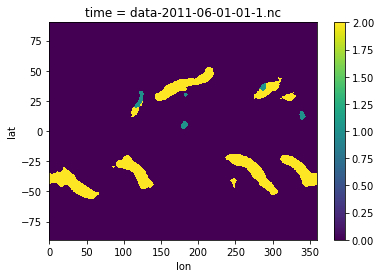

In [32]:
test_masks.isel(time=0).plot();

## Save out test data masks

In [35]:
%%time
test_masks.name = 'masks'
test_masks.to_netcdf("/glade/campaign/cgd/ccr/kdagon/cgnet/evaluate/test_masks.040523.nc") # trained_cgnet.040523 applied to test data to evaluate predictions vs. labels

CPU times: user 2.35 ms, sys: 142 ms, total: 144 ms
Wall time: 168 ms


## Set inference data

In [38]:
year=2000
#inference_path = "/glade/campaign/cgd/amp/jet/ClimateNet/Climate_data_"+str(year)
#inference_path = "/glade/scratch/tking/cgnet/historical_2000_2005/split_files"
inference_path = "/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/"+str(year)

inference = ClimateDataset(inference_path, config)  # could test different config with std/means for inference data

In [39]:
inference.fields

{'TMQ': {'mean': 24.927238169017997, 'std': 15.817276954650879},
 'U850': {'mean': 1.0356735863118816, 'std': 8.29762077331543},
 'V850': {'mean': 0.20847854977498861, 'std': 6.231630802154541},
 'PSL': {'mean': 101095.03520124489, 'std': 1461.225830078125}}

In [40]:
inference.length

17520

## Inference mode
This is now done more systematically in `cgnet_run_pre_trained_model.ipynb`.

In [35]:
%%time
class_masks = cgnet.predict(inference) # masks with 1==TC, 2==AR

100%|██████████| 183/183 [06:38<00:00,  2.18s/it]


CPU times: user 2min 17s, sys: 1min 8s, total: 3min 26s
Wall time: 6min 46s


## Save out masks

In [36]:
%%time
class_masks.to_netcdf("/glade/scratch/kdagon/cgnet/class_masks."+str(year)+".nc")

CPU times: user 55.9 ms, sys: 4.16 s, total: 4.22 s
Wall time: 7.53 s


## Track events
Create masks with event IDs

Note: memory spikes here - resource intensive!

In [ ]:
%%time
event_masks = track_events(class_masks)

In [ ]:
%%time
event_masks.to_netcdf("/glade/scratch/kdagon/cgnet/event_masks."+str(year)+".test.nc")

## Analyze events
Produce some visualizations

In [ ]:
analyze_events(event_masks, class_masks, "/glade/scratch/kdagon/cgnet/")

In [ ]:
visualize_events(event_masks, inference, "/glade/scratch/kdagon/cgnet/")   

## Weights and Biases
https://docs.wandb.ai/quickstart \
Potential tool for hyperparameter optimization\
Still figuring out how this works...

In [42]:
import wandb

In [44]:
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········


wandb: Appending key for api.wandb.ai to your netrc file: /glade/u/home/kdagon/.netrc


True

In [46]:
wandb.init(project="climatenet-test", entity="katie-dagon")

Ignoring settings passed to wandb.setup() which has already been configured.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········


wandb: Appending key for api.wandb.ai to your netrc file: /glade/u/home/kdagon/.netrc
wandb: wandb version 0.13.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20230215_172859-2auiboc1
wandb: Syncing run decent-river-1


In [47]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 20,
  "batch_size": 16
}

In [49]:
wandb.log({"loss": loss})

NameError: name 'loss' is not defined